# Regularization and Evaluation of Neural Networks

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.confusion import plot_confusion_matrix
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [2]:
digits = load_digits()
X = digits.data.astype('float32')
y = digits.target.astype('float32')

y_binary = y % 2

In [3]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 0s 522us/step - loss: 0.4689 - accuracy: 0.7590
Epoch 2/50
180/180 [==============================] - 0s 511us/step - loss: 0.2658 - accuracy: 0.8843
Epoch 3/50
180/180 [==============================] - 0s 497us/step - loss: 0.1834 - accuracy: 0.9232
Epoch 4/50
180/180 [==============================] - 0s 508us/step - loss: 0.1380 - accuracy: 0.9410
Epoch 5/50
180/180 [==============================] - 0s 501us/step - loss: 0.1084 - accuracy: 0.9538
Epoch 6/50
180/180 [==============================] - 0s 496us/step - loss: 0.0906 - accuracy: 0.9672
Epoch 7/50
180/180 [==============================] - 0s 503us/step - loss: 0.0787 - accuracy: 0.9716
Epoch 8/50
180/180 [==============================] - 0s 485us/step - loss: 0.0666 - accuracy: 0.9761
Epoch 9/50
180/180 [==============================] - 0s 494us/step - loss: 0.0609 - accuracy: 0.9777
Epoch 10/50
180/180 [==============================] - 0s 501us/step - loss: 0.052

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling

**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [9]:
# THIS IS HOW I CAN SEE HOW BIG THE MAX PIXELS ARE

X_train.max()

16.0

In [10]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.],
      dtype=float32)

In [11]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

### Sigmoid 

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [12]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 645us/step - loss: 0.7255 - accuracy: 0.5039
Epoch 2/10
12/12 [==============================] - 0s 559us/step - loss: 0.7191 - accuracy: 0.5039
Epoch 3/10
12/12 [==============================] - 0s 501us/step - loss: 0.7138 - accuracy: 0.5039
Epoch 4/10
12/12 [==============================] - 0s 557us/step - loss: 0.7093 - accuracy: 0.5039
Epoch 5/10
12/12 [==============================] - 0s 545us/step - loss: 0.7057 - accuracy: 0.5039
Epoch 6/10
12/12 [==============================] - 0s 545us/step - loss: 0.7027 - accuracy: 0.5039
Epoch 7/10
12/12 [==============================] - 0s 580us/step - loss: 0.7002 - accuracy: 0.5039
Epoch 8/10
12/12 [==============================] - 0s 597us/step - loss: 0.6982 - accuracy: 0.5039
Epoch 9/10
12/12 [==============================] - 0s 584us/step - loss: 0.6966 - accuracy: 0.5039
Epoch 10/10
12/12 [==============================] - 0s 500us/step - loss: 0.6954 - accuracy: 0.5039

We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [14]:
# dict

results.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x229f94469a0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7255355715751648,
   0.7191224098205566,
   0.7137599587440491,
   0.7092949151992798,
   0.7056792378425598,
   0.7026702165603638,
   0.7001891136169434,
   0.6981884837150574,
   0.6965607404708862,
   0.6954020857810974],
  'accuracy': [0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [15]:
results.history

{'loss': [0.7255355715751648,
  0.7191224098205566,
  0.7137599587440491,
  0.7092949151992798,
  0.7056792378425598,
  0.7026702165603638,
  0.7001891136169434,
  0.6981884837150574,
  0.6965607404708862,
  0.6954020857810974],
 'accuracy': [0.5039164423942566,
  0.5039164423942566,
  0.5039164423942566,
  0.5039164423942566,
  0.5039164423942566,
  0.5039164423942566,
  0.5039164423942566,
  0.5039164423942566,
  0.5039164423942566,
  0.5039164423942566]}

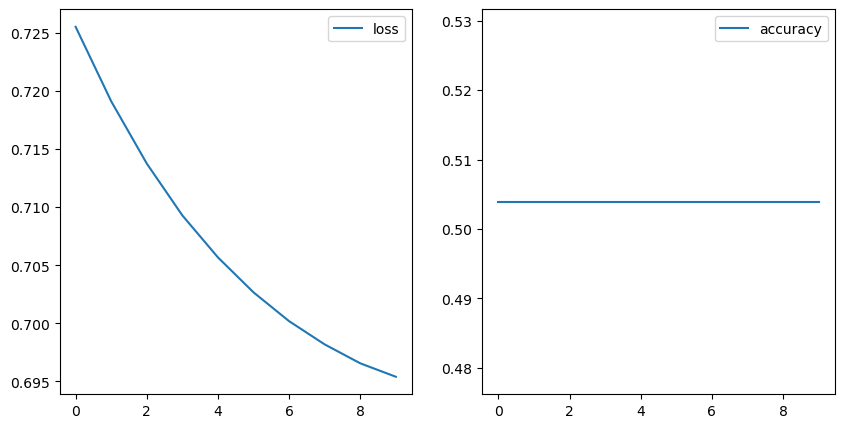

In [16]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

## Basic Model Tuning

### Increase Epochs

In [17]:
model = Sequential()
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs

results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=100, verbose=1)


Epoch 1/100
12/12 [==============================] - 0s 640us/step - loss: 0.6985 - accuracy: 0.5057
Epoch 2/100
12/12 [==============================] - 0s 548us/step - loss: 0.6983 - accuracy: 0.5048
Epoch 3/100
12/12 [==============================] - 0s 546us/step - loss: 0.6980 - accuracy: 0.4987
Epoch 4/100
12/12 [==============================] - 0s 545us/step - loss: 0.6978 - accuracy: 0.4891
Epoch 5/100
12/12 [==============================] - 0s 556us/step - loss: 0.6976 - accuracy: 0.4787
Epoch 6/100
12/12 [==============================] - 0s 554us/step - loss: 0.6974 - accuracy: 0.4613
Epoch 7/100
12/12 [==============================] - 0s 548us/step - loss: 0.6973 - accuracy: 0.4465
Epoch 8/100
12/12 [==============================] - 0s 546us/step - loss: 0.6970 - accuracy: 0.4230
Epoch 9/100
12/12 [==============================] - 0s 546us/step - loss: 0.6969 - accuracy: 0.4108
Epoch 10/100
12/12 [==============================] - 0s 455us/step - loss: 0.6967 - accura

12/12 [==============================] - 0s 592us/step - loss: 0.6869 - accuracy: 0.6353
Epoch 82/100
12/12 [==============================] - 0s 469us/step - loss: 0.6867 - accuracy: 0.6362
Epoch 83/100
12/12 [==============================] - 0s 592us/step - loss: 0.6866 - accuracy: 0.6423
Epoch 84/100
12/12 [==============================] - 0s 455us/step - loss: 0.6865 - accuracy: 0.6493
Epoch 85/100
12/12 [==============================] - 0s 592us/step - loss: 0.6863 - accuracy: 0.6519
Epoch 86/100
12/12 [==============================] - 0s 493us/step - loss: 0.6862 - accuracy: 0.6545
Epoch 87/100
12/12 [==============================] - 0s 454us/step - loss: 0.6860 - accuracy: 0.6562
Epoch 88/100
12/12 [==============================] - 0s 546us/step - loss: 0.6859 - accuracy: 0.6623
Epoch 89/100
12/12 [==============================] - 0s 501us/step - loss: 0.6858 - accuracy: 0.6632
Epoch 90/100
12/12 [==============================] - 0s 554us/step - loss: 0.6856 - accuracy: 

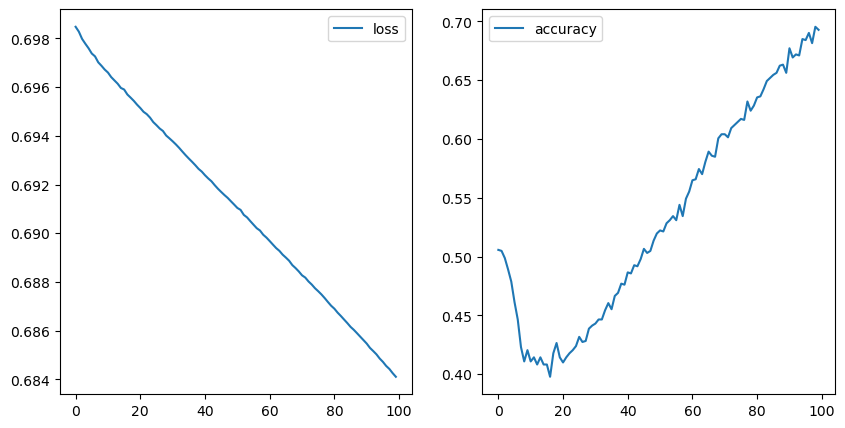

In [18]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Decrease Batch Size

In [20]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# decrease batch size
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=10, verbose=1)

Epoch 1/10
115/115 [==============================] - 0s 512us/step - loss: 0.8071 - accuracy: 0.5039
Epoch 2/10
115/115 [==============================] - 0s 496us/step - loss: 0.7225 - accuracy: 0.5039
Epoch 3/10
115/115 [==============================] - 0s 504us/step - loss: 0.7031 - accuracy: 0.5039
Epoch 4/10
115/115 [==============================] - 0s 474us/step - loss: 0.6979 - accuracy: 0.5039
Epoch 5/10
115/115 [==============================] - 0s 467us/step - loss: 0.6963 - accuracy: 0.5039
Epoch 6/10
115/115 [==============================] - 0s 479us/step - loss: 0.6955 - accuracy: 0.4030
Epoch 7/10
115/115 [==============================] - 0s 492us/step - loss: 0.6951 - accuracy: 0.4134
Epoch 8/10
115/115 [==============================] - 0s 485us/step - loss: 0.6945 - accuracy: 0.4830
Epoch 9/10
115/115 [==============================] - 0s 477us/step - loss: 0.6940 - accuracy: 0.4656
Epoch 10/10
115/115 [==============================] - 0s 475us/step - loss: 0.693

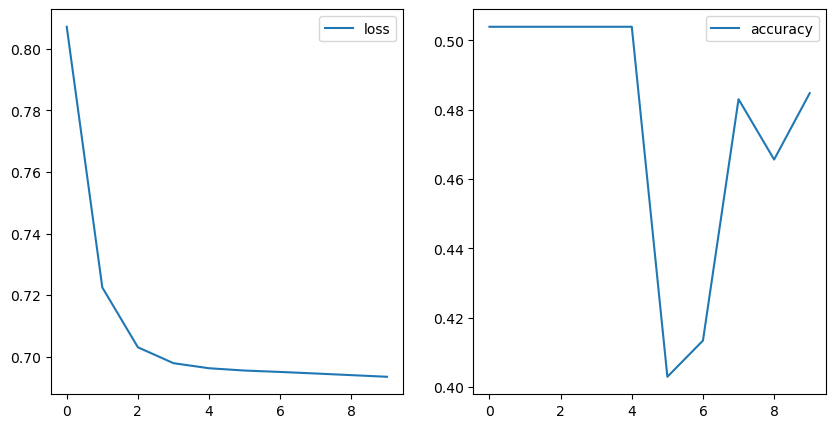

In [21]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Both

In [22]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# increase epochs decrease batch size
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=10, verbose=1)

Epoch 1/100
115/115 [==============================] - 0s 488us/step - loss: 0.6997 - accuracy: 0.5039
Epoch 2/100
115/115 [==============================] - 0s 485us/step - loss: 0.6934 - accuracy: 0.5187
Epoch 3/100
115/115 [==============================] - 0s 478us/step - loss: 0.6917 - accuracy: 0.5570
Epoch 4/100
115/115 [==============================] - 0s 482us/step - loss: 0.6903 - accuracy: 0.5466
Epoch 5/100
115/115 [==============================] - 0s 483us/step - loss: 0.6891 - accuracy: 0.6005
Epoch 6/100
115/115 [==============================] - 0s 472us/step - loss: 0.6878 - accuracy: 0.6440
Epoch 7/100
115/115 [==============================] - 0s 481us/step - loss: 0.6866 - accuracy: 0.6867
Epoch 8/100
115/115 [==============================] - 0s 464us/step - loss: 0.6854 - accuracy: 0.7154
Epoch 9/100
115/115 [==============================] - 0s 476us/step - loss: 0.6840 - accuracy: 0.6997
Epoch 10/100
115/115 [==============================] - 0s 473us/step - l

115/115 [==============================] - 0s 483us/step - loss: 0.2921 - accuracy: 0.8938
Epoch 80/100
115/115 [==============================] - 0s 471us/step - loss: 0.2891 - accuracy: 0.8964
Epoch 81/100
115/115 [==============================] - 0s 476us/step - loss: 0.2866 - accuracy: 0.8956
Epoch 82/100
115/115 [==============================] - 0s 490us/step - loss: 0.2841 - accuracy: 0.8947
Epoch 83/100
115/115 [==============================] - 0s 495us/step - loss: 0.2818 - accuracy: 0.8956
Epoch 84/100
115/115 [==============================] - 0s 490us/step - loss: 0.2795 - accuracy: 0.8973
Epoch 85/100
115/115 [==============================] - 0s 474us/step - loss: 0.2776 - accuracy: 0.8956
Epoch 86/100
115/115 [==============================] - 0s 473us/step - loss: 0.2751 - accuracy: 0.8956
Epoch 87/100
115/115 [==============================] - 0s 478us/step - loss: 0.2732 - accuracy: 0.8973
Epoch 88/100
115/115 [==============================] - 0s 467us/step - loss:

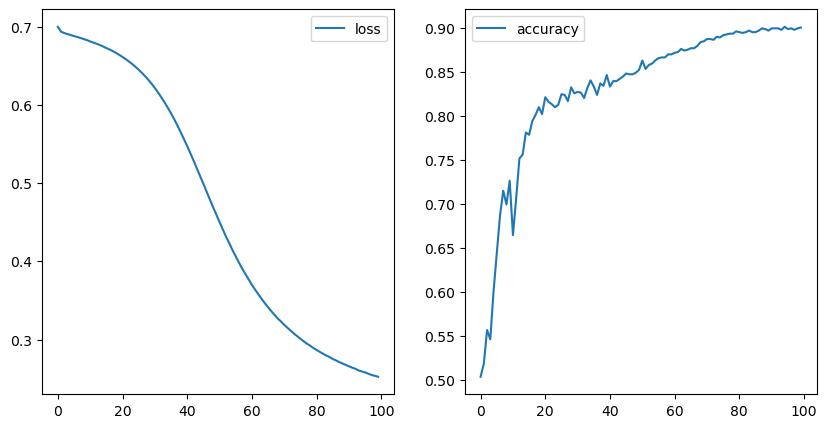

In [23]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Use Relu

In [24]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs, decrease batchsize


results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 591us/step - loss: 0.7063 - accuracy: 0.5083
Epoch 2/10
12/12 [==============================] - 0s 592us/step - loss: 0.6797 - accuracy: 0.5692
Epoch 3/10
12/12 [==============================] - 0s 548us/step - loss: 0.6659 - accuracy: 0.6075
Epoch 4/10
12/12 [==============================] - 0s 546us/step - loss: 0.6561 - accuracy: 0.6379
Epoch 5/10
12/12 [==============================] - 0s 546us/step - loss: 0.6474 - accuracy: 0.6745
Epoch 6/10
12/12 [==============================] - 0s 501us/step - loss: 0.6391 - accuracy: 0.7050
Epoch 7/10
12/12 [==============================] - 0s 607us/step - loss: 0.6311 - accuracy: 0.7076
Epoch 8/10
12/12 [==============================] - 0s 500us/step - loss: 0.6232 - accuracy: 0.7363
Epoch 9/10
12/12 [==============================] - 0s 545us/step - loss: 0.6153 - accuracy: 0.7450
Epoch 10/10
12/12 [==============================] - 0s 455us/step - loss: 0.6075 - accuracy: 0.7572

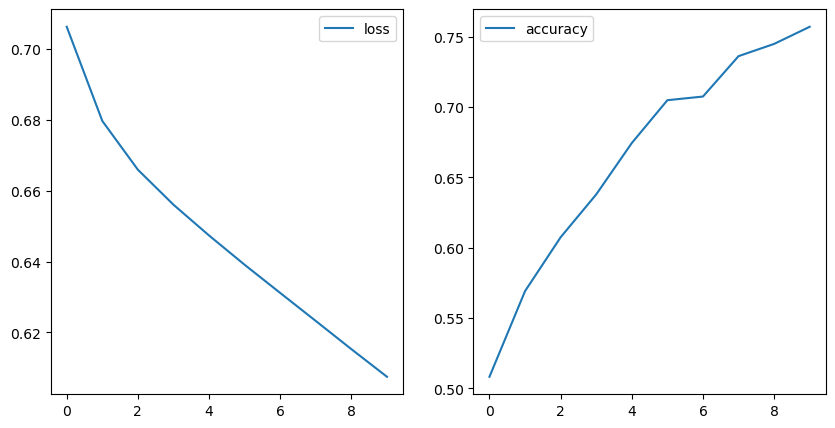

In [25]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### All of it (epochs, batch, relu)

In [26]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs


results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=10, verbose=1)

Epoch 1/100
115/115 [==============================] - 0s 466us/step - loss: 0.6865 - accuracy: 0.5483
Epoch 2/100
115/115 [==============================] - 0s 500us/step - loss: 0.6226 - accuracy: 0.7328
Epoch 3/100
115/115 [==============================] - 0s 468us/step - loss: 0.5348 - accuracy: 0.8059
Epoch 4/100
115/115 [==============================] - 0s 462us/step - loss: 0.4546 - accuracy: 0.8346
Epoch 5/100
115/115 [==============================] - 0s 468us/step - loss: 0.3901 - accuracy: 0.8599
Epoch 6/100
115/115 [==============================] - 0s 482us/step - loss: 0.3442 - accuracy: 0.8721
Epoch 7/100
115/115 [==============================] - 0s 463us/step - loss: 0.3154 - accuracy: 0.8834
Epoch 8/100
115/115 [==============================] - 0s 462us/step - loss: 0.2914 - accuracy: 0.8851
Epoch 9/100
115/115 [==============================] - 0s 462us/step - loss: 0.2754 - accuracy: 0.8947
Epoch 10/100
115/115 [==============================] - 0s 459us/step - l

115/115 [==============================] - 0s 436us/step - loss: 0.0658 - accuracy: 0.9756
Epoch 80/100
115/115 [==============================] - 0s 432us/step - loss: 0.0627 - accuracy: 0.9809
Epoch 81/100
115/115 [==============================] - 0s 416us/step - loss: 0.0621 - accuracy: 0.9817
Epoch 82/100
115/115 [==============================] - 0s 459us/step - loss: 0.0586 - accuracy: 0.9809
Epoch 83/100
115/115 [==============================] - 0s 427us/step - loss: 0.0592 - accuracy: 0.9817
Epoch 84/100
115/115 [==============================] - 0s 485us/step - loss: 0.0573 - accuracy: 0.9826
Epoch 85/100
115/115 [==============================] - 0s 487us/step - loss: 0.0557 - accuracy: 0.9826
Epoch 86/100
115/115 [==============================] - 0s 430us/step - loss: 0.0552 - accuracy: 0.9852
Epoch 87/100
115/115 [==============================] - 0s 437us/step - loss: 0.0531 - accuracy: 0.9826
Epoch 88/100
115/115 [==============================] - 0s 440us/step - loss:

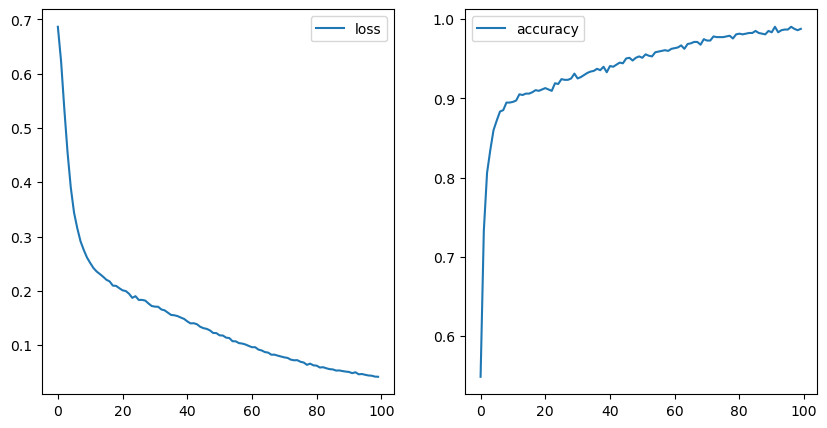

In [27]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Side note: learning rate

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
  1/115 [..............................] - ETA: 16s - loss: 0.9158 - accuracy: 0.3000

C:\Users\nacnu\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


115/115 [==============================] - 0s 499us/step - loss: 1.0827 - accuracy: 0.5048
Epoch 2/30
115/115 [==============================] - 0s 487us/step - loss: 0.9691 - accuracy: 0.5030
Epoch 3/30
115/115 [==============================] - 0s 490us/step - loss: 0.9684 - accuracy: 0.4943
Epoch 4/30
115/115 [==============================] - 0s 483us/step - loss: 1.0393 - accuracy: 0.4839
Epoch 5/30
115/115 [==============================] - 0s 494us/step - loss: 0.9600 - accuracy: 0.4917
Epoch 6/30
115/115 [==============================] - 0s 466us/step - loss: 1.0047 - accuracy: 0.4917
Epoch 7/30
115/115 [==============================] - 0s 487us/step - loss: 0.9311 - accuracy: 0.4996
Epoch 8/30
115/115 [==============================] - 0s 454us/step - loss: 1.0931 - accuracy: 0.4735
Epoch 9/30
115/115 [==============================] - 0s 474us/step - loss: 0.9308 - accuracy: 0.5239
Epoch 10/30
115/115 [==============================] - 0s 499us/step - loss: 0.9471 - accurac

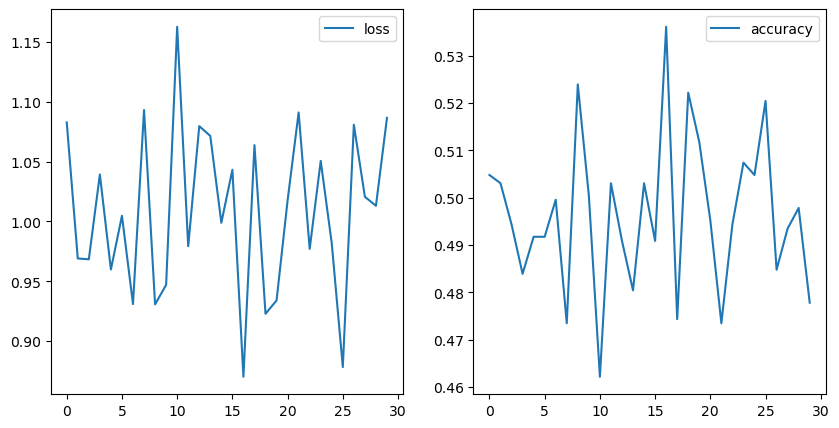

In [28]:
model = Sequential()

sgd = SGD(lr=9)


model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();


### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/30
115/115 [==============================] - 0s 1ms/step - loss: 0.6575 - accuracy: 0.5457 - val_loss: 0.6043 - val_accuracy: 0.7674
Epoch 2/30
115/115 [==============================] - 0s 853us/step - loss: 0.5626 - accuracy: 0.7668 - val_loss: 0.4997 - val_accuracy: 0.8299
Epoch 3/30
115/115 [==============================] - 0s 857us/step - loss: 0.4837 - accuracy: 0.8425 - val_loss: 0.4421 - val_accuracy: 0.8785
Epoch 4/30
115/115 [==============================] - 0s 854us/step - loss: 0.4320 - accuracy: 0.8790 - val_loss: 0.3978 - val_accuracy: 0.9028
Epoch 5/30
115/115 [==============================] - 0s 840us/step - loss: 0.3961 - accuracy: 0.8990 - val_loss: 0.3640 - val_accuracy: 0.9062
Epoch 6/30
115/115 [==============================] - 0s 869us/step - loss: 0.3632 - accuracy: 0.9138 - val_loss: 0.3470 - val_accuracy: 0.8889
Epoch 7/30
115/115 [==============================] - 0s 842us/step - loss: 0.3432 - accuracy: 0.9121 - val_loss: 0.3271 - val_accuracy: 0

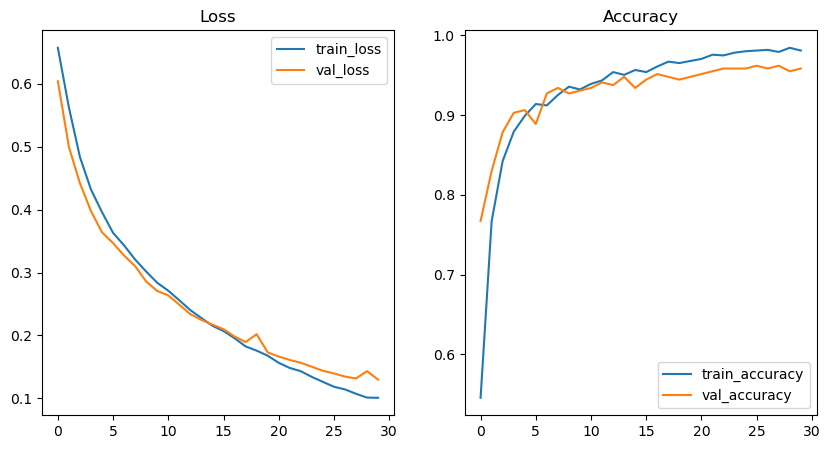

In [29]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE
results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1,
                    validation_data=(X_val, y_val))



train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [31]:
results.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
results.history['val_accuracy'][-1]

0.9583333134651184

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [32]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x00000229EF378C40> does not.

In [33]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [34]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=10,
                                          batch_size=32,
                                          verbose=2)

C:\Users\nacnu\AppData\Local\Temp\ipykernel_16500\348061558.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = scikit_learn.KerasClassifier(build_model,


In [35]:
type(keras_model)

keras.wrappers.scikit_learn.KerasClassifier

In [36]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/10
29/29 - 0s - loss: 0.7091 - accuracy: 0.5158 - 196ms/epoch - 7ms/step
Epoch 2/10
29/29 - 0s - loss: 0.6144 - accuracy: 0.5767 - 16ms/epoch - 568us/step
Epoch 3/10
29/29 - 0s - loss: 0.5536 - accuracy: 0.6964 - 16ms/epoch - 561us/step
Epoch 4/10
29/29 - 0s - loss: 0.5130 - accuracy: 0.8020 - 17ms/epoch - 572us/step
Epoch 5/10
29/29 - 0s - loss: 0.4872 - accuracy: 0.8422 - 17ms/epoch - 587us/step
Epoch 6/10
29/29 - 0s - loss: 0.4664 - accuracy: 0.8683 - 15ms/epoch - 522us/step
Epoch 7/10
29/29 - 0s - loss: 0.4516 - accuracy: 0.8814 - 18ms/epoch - 604us/step
Epoch 8/10
29/29 - 0s - loss: 0.4351 - accuracy: 0.9010 - 16ms/epoch - 535us/step
Epoch 9/10
29/29 - 0s - loss: 0.4209 - accuracy: 0.9021 - 16ms/epoch - 563us/step
Epoch 10/10
29/29 - 0s - loss: 0.4090 - accuracy: 0.9108 - 16ms/epoch - 566us/step
8/8 - 0s - loss: 0.3995 - accuracy: 0.8739 - 55ms/epoch - 7ms/step
Epoch 1/10
29/29 - 0s - loss: 0.6740 - accuracy: 0.5201 - 199ms/epoch - 7ms/step
Epoch 2/10
29/29 - 0s - loss: 0.

array([0.87391305, 0.89999998, 0.9173913 , 0.92608696, 0.87336242])

## [Regularization](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

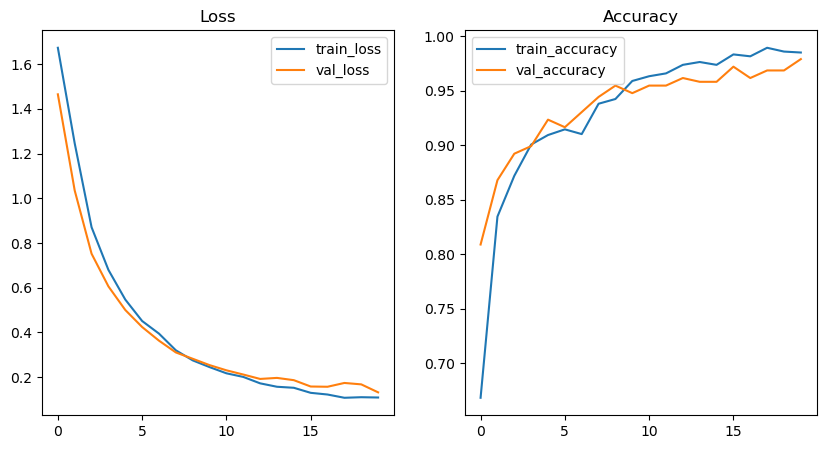

In [37]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',kernel_regularizer=l2(l=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

Adding L2 to multiple layers:

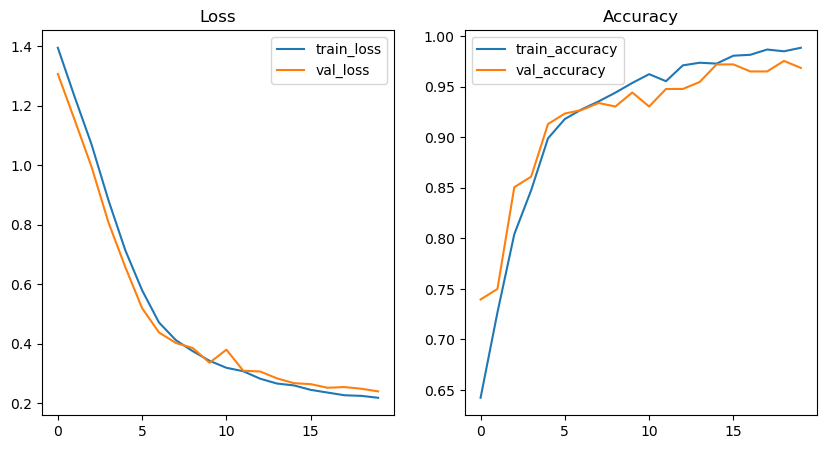

In [38]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

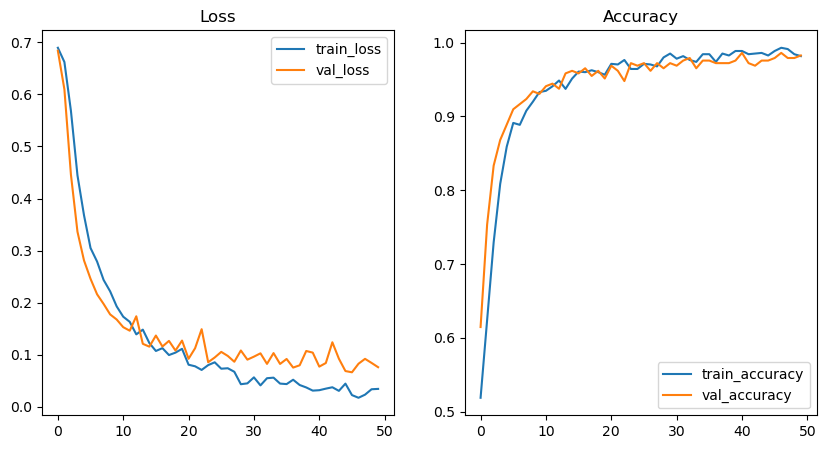

In [51]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))

model.add(Dropout(0.25))

model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [52]:
results.history['val_accuracy'][-1]

0.9826388955116272

In [53]:
results.history['accuracy'][-1]

0.9817232489585876

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 2: early stopping


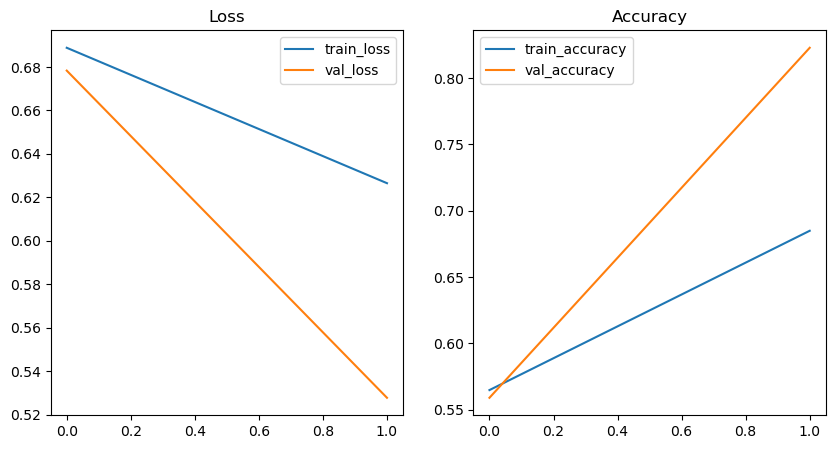

In [55]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 29: early stopping


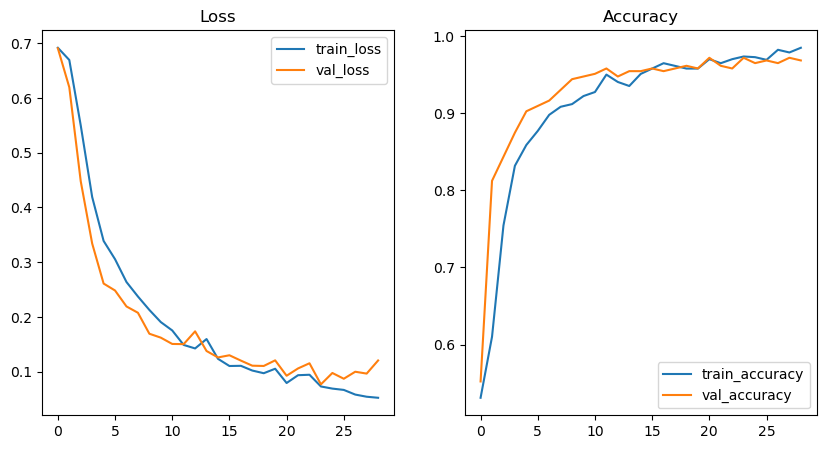

In [57]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min',
                           patience=5)

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [58]:
results.history['val_accuracy'][-1]

0.96875

In [60]:
results.history['accuracy'][-1]

0.9852045178413391

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [61]:
digits = load_digits()
X = digits.data
y = digits.target

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [63]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

C:\Users\nacnu\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [64]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [65]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 0s 1ms/step - loss: 2.1787 - accuracy: 0.1915 - val_loss: 2.0155 - val_accuracy: 0.3576
Epoch 2/50
115/115 [==============================] - 0s 835us/step - loss: 1.8346 - accuracy: 0.4212 - val_loss: 1.5885 - val_accuracy: 0.4826
Epoch 3/50
115/115 [==============================] - 0s 803us/step - loss: 1.4291 - accuracy: 0.5074 - val_loss: 1.2322 - val_accuracy: 0.5938
Epoch 4/50
115/115 [==============================] - 0s 798us/step - loss: 1.1284 - accuracy: 0.6371 - val_loss: 1.0112 - val_accuracy: 0.7083
Epoch 5/50
115/115 [==============================] - 0s 823us/step - loss: 0.9335 - accuracy: 0.7258 - val_loss: 0.8556 - val_accuracy: 0.7674
Epoch 6/50
115/115 [==============================] - 0s 844us/step - loss: 0.7845 - accuracy: 0.7781 - val_loss: 0.7264 - val_accuracy: 0.7951
Epoch 7/50
115/115 [==============================] - 0s 851us/step - loss: 0.6581 - accuracy: 0.8138 - val_loss: 0.6454 - val_accuracy: 0

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [66]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

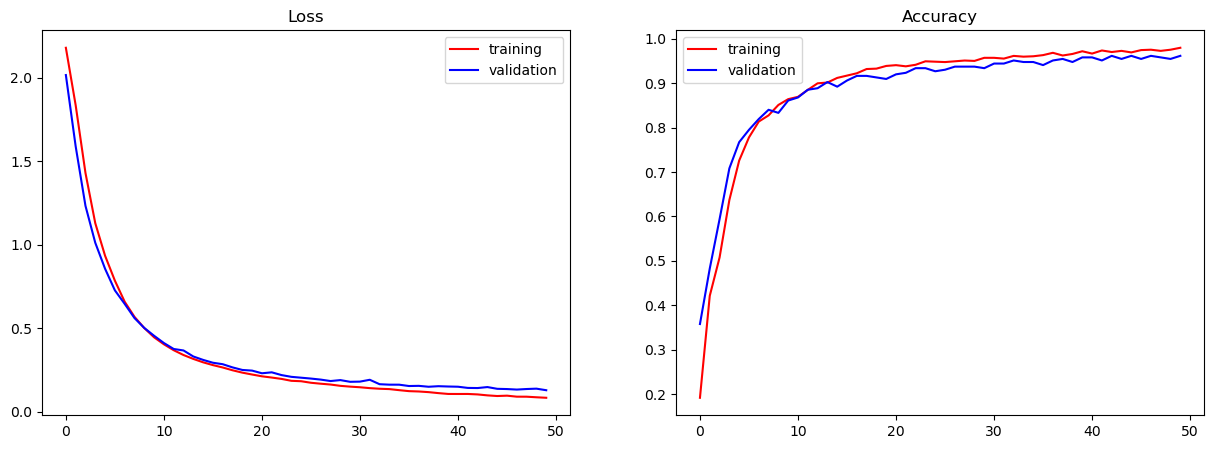

In [67]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)

ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
